In [7]:
import pandas as pd
import numpy as np


# time

import os
import sys
import time
from datetime import datetime
from datetime import date

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

# Labelizer
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize


# Normalize 

from sklearn.preprocessing import MinMaxScaler

from sklearn.multiclass import OneVsRestClassifier

# Boosting classifiers


from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Save model
import pickle
import joblib

In [8]:
fileName = '1_Director_Data_Mar-21-2020'
# fileName = '2_Director_Data_Enhanced_May-10-2020'
# fileName = '3_USA_Director_Specific_dataset_May-15-2020'

directorDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\'+ fileName +'.csv')


# moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\.csv')
# moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\.csv')
# moviesDataFileLocation = os.path.join(os.path.realpath(os.path.pardir),'datasets\\.csv')



saveFileToPath = "C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\"

director_data = pd.read_csv(directorDataFileLocation)

### Drop rows for visualization

In [9]:
index_career_length_101 = director_data[director_data['career_Length']==101].index

In [10]:
index_birth_year_6 = director_data[director_data['birthYear'] == 6].index

In [11]:
director_data.drop(index_career_length_101.union(index_birth_year_6),inplace = True)

In [12]:
director_data.columns.values

array(['director_ids', 'director_name', 'movies_produced',
       'average_rating_value', 'average_rating_count', 'career_Length',
       'Gender', 'birthYear', 'primaryProfession', 'knownForTitles',
       'CareerStartYear', 'median_inter_event_time',
       'average_movie_per_year', 'average_inter_event_time'], dtype=object)

In [13]:
director_data.shape

(41626, 14)

In [14]:
director_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41626 entries, 0 to 41628
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   director_ids              41626 non-null  object 
 1   director_name             41626 non-null  object 
 2   movies_produced           41626 non-null  int64  
 3   average_rating_value      41626 non-null  float64
 4   average_rating_count      41626 non-null  float64
 5   career_Length             41626 non-null  int64  
 6   Gender                    41626 non-null  object 
 7   birthYear                 41626 non-null  int64  
 8   primaryProfession         41626 non-null  object 
 9   knownForTitles            41626 non-null  object 
 10  CareerStartYear           41626 non-null  int64  
 11  median_inter_event_time   41626 non-null  float64
 12  average_movie_per_year    41626 non-null  float64
 13  average_inter_event_time  41626 non-null  float64
dtypes: flo

# Notebook Run Settings

chosen_feature_predicting : rating_count , rating_value , review_count_critic , review_count_user , metascore
<br>chosen_bin_method : quartiles , bin_cut , Bin_AsPaper
<br>chosen_success_class : movie_rating , director_rating
<br>chosen_dataset_balance : unbalanced , balanced
<br>chosen_scaling_method : MinMaxScaler , None

In [15]:
gender_as_an_input = 'Yes'
chosen_feature_predicting = 'average_rating_count'
chosen_bin_method = 'quartiles'
chosen_success_class = 'director_class'
chosen_dataset_ratio = 'unbalanced'
chosen_scaling_method = 'None'
default_learning_rate = 0.1
chosen_max_leaf_nodes = 32
default_max_depth = 3
chosen_max_features = None
chosen_random_state = 42

## Success classes

In [16]:
def undersampling_balanced_gender(df,balance_feature = 'Gender', column_tobe_unique = 'director_ids'):
    
    # Shuffle the Dataset.
    shuffled_data = df.sample(frac=1,random_state=42)
    print('Unbalanced dataframe shape before undersampling :',shuffled_data.shape)

    # First remove all duplicates director_ids to have only unique columns
    unique_column_df = shuffled_data.drop_duplicates(subset = column_tobe_unique, keep='first', inplace=False)
    unique_column_df.shape
    
    # An empty balanced data frame with only the unique columns
    bal_total_unique_list_df = pd.DataFrame()
    
    # Add balanced values from all the possible classes    
    for i in unique_column_df[balance_feature].value_counts().index:
        bal_total_unique_list_df = bal_total_unique_list_df.append(unique_column_df[(unique_column_df[balance_feature]==i)]
                                                   .sample(
                                                       n= unique_column_df[balance_feature].value_counts().values.min(),
                                                       random_state = 42,
                                                       replace = False)
                                                  )
    # list of unique IDs
    total_list_unique_IDs = bal_total_unique_list_df[column_tobe_unique].to_list()
    
    balanced_data = shuffled_data[shuffled_data[column_tobe_unique].isin(total_list_unique_IDs)] 
    
    print('Balanced dataframe shape after undersampling :',balanced_data.shape)
    return balanced_data

# Functions : Bin Cuts , Quartile Bins and bins as in paper

## Quartile Bins

In [17]:
def quartile_bin(df,class_feature='rating_value'):
    # Quartile cut into 4 different buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.qcut(df[class_feature].to_list(), q=4,labels=bin_quartiles)
    
    print(cutIntoQuartiles.categories)
    
    df[chosen_success_class] = cutIntoQuartiles
    df[chosen_success_class] = df[chosen_success_class].astype(object)
    print('The shape of our dataset is:', df.shape)
    return df

# Function - To choose which Success measure to choose and what binning technique

In [18]:
def choose_success_measure(df, bin_method = 'Quartiles', feature = 'rating_value'):
    
    # Stats of the feature
    print('\nDescribing the feature : \n')
    print(df[feature].describe())
    

    
    if (bin_method == 'quartiles'):
        # Quartie bin cuts
        df = quartile_bin(df,feature)
            
    elif(bin_method == 'bin_cut'):
        # Bin cuts
        df = bincuts(df,'rating_value')
        
    elif(bin_method == 'Bin_AsPaper'):
        df[chosen_success_class] = df[feature].apply(success_measure).astype('category')
        
    print('\nShape of the dataset : \n')
    print('\nThe shape of our Movies dataset is:', df.shape)
#     df.drop(columns = [feature] , inplace = True)
    print('\nThe shape of our Movies dataset is:', df.shape)
    
    print('\nValue Count of the bucketed class is : \n')
    print(df[chosen_success_class].value_counts())

### Balance Gender

In [19]:
balanced_director_data = undersampling_balanced_gender(director_data)

Unbalanced dataframe shape before undersampling : (41626, 14)
Balanced dataframe shape after undersampling : (17980, 14)


In [20]:
balanced_director_data.shape

(17980, 14)

### Choosing dataset for the analysis

In [21]:
chosen_dataset_ratio

'unbalanced'

In [22]:
chosen_dataframe = ''
if(chosen_dataset_ratio == 'unbalanced'):
    chosen_dataframe = director_data
elif(chosen_dataset_ratio == 'balanced'):
    chosen_dataframe = balanced_director_data

### Remove Features from dataset which are not required

In [23]:
object_features_to_remove = chosen_dataframe.select_dtypes(include = 'object').columns.values.tolist()
object_features_to_remove.remove('Gender')
object_features_to_remove

['director_ids', 'director_name', 'primaryProfession', 'knownForTitles']

## Run the feature based on the bin cut and success feature

In [24]:
chosen_feature_predicting

'average_rating_count'

In [25]:
cutIntoQuartiles = pd.qcut(chosen_dataframe[chosen_feature_predicting].to_list(), q=4)
print("Quantiles bin range")
for i,num in enumerate(cutIntoQuartiles.categories):
    print("Quantile {0} : {1} ".format(i,num))

Quantiles bin range
Quantile 0 : (4.999, 12.67] 
Quantile 1 : (12.67, 34.0] 
Quantile 2 : (34.0, 147.825] 
Quantile 3 : (147.825, 690249.0] 


In [26]:
choose_success_measure(chosen_dataframe , bin_method = chosen_bin_method , feature = chosen_feature_predicting)


Describing the feature : 

count     41626.000000
mean       1398.473128
std       11699.669580
min           5.000000
25%          12.670000
50%          34.000000
75%         147.825000
max      690249.000000
Name: average_rating_count, dtype: float64
Index(['terrible', 'poor', 'average', 'excellent'], dtype='object')
The shape of our dataset is: (41626, 15)

Shape of the dataset : 


The shape of our Movies dataset is: (41626, 15)

The shape of our Movies dataset is: (41626, 15)

Value Count of the bucketed class is : 

poor         10477
terrible     10431
excellent    10407
average      10311
Name: director_class, dtype: int64


In [27]:
chosen_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41626 entries, 0 to 41628
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   director_ids              41626 non-null  object 
 1   director_name             41626 non-null  object 
 2   movies_produced           41626 non-null  int64  
 3   average_rating_value      41626 non-null  float64
 4   average_rating_count      41626 non-null  float64
 5   career_Length             41626 non-null  int64  
 6   Gender                    41626 non-null  object 
 7   birthYear                 41626 non-null  int64  
 8   primaryProfession         41626 non-null  object 
 9   knownForTitles            41626 non-null  object 
 10  CareerStartYear           41626 non-null  int64  
 11  median_inter_event_time   41626 non-null  float64
 12  average_movie_per_year    41626 non-null  float64
 13  average_inter_event_time  41626 non-null  float64
 14  direct

### Chosen Director Dataset

In [28]:
print('The shape of our chosen director dataset before removing object type features:', chosen_dataframe.shape)
# movies_data = movies_data[movies_data.columns.difference(object_features_to_remove)]
chosen_dataframe = chosen_dataframe.drop(columns= object_features_to_remove)
print('The shape of our chosen director dataset after dropping object type features:', chosen_dataframe.shape)

The shape of our chosen director dataset before removing object type features: (41626, 15)
The shape of our chosen director dataset after dropping object type features: (41626, 11)


In [29]:
chosen_dataframe[chosen_success_class].value_counts()

poor         10477
terrible     10431
excellent    10407
average      10311
Name: director_class, dtype: int64

In [30]:
chosen_dataframe.head()

,movies_produced,average_rating_value,average_rating_count,career_Length,Gender,birthYear,CareerStartYear,median_inter_event_time,average_movie_per_year,average_inter_event_time,director_class
0,70,7.36,6984.76,63,Male,1918,1946,1.0,1.11,0.9,excellent
1,1,7.20,7002.00,1,Male,1924,1961,0.0,1.00,0.0,excellent
2,1,5.70,676.00,1,Male,1925,1967,0.0,1.00,0.0,excellent
3,1,5.80,162.00,1,Male,1899,1957,0.0,1.00,0.0,excellent
4,2,5.85,722.50,3,Male,1916,1973,2.0,0.67,2.0,excellent


# Visualizations

In [31]:
visualize_data = chosen_dataframe.copy()

In [32]:
balanced_visualize_data = balanced_director_data.copy()

In [33]:
choose_success_measure(balanced_visualize_data , bin_method = chosen_bin_method , feature = chosen_feature_predicting)


Describing the feature : 

count     17980.000000
mean       1285.895482
std       11619.821481
min           5.000000
25%          12.185000
50%          33.330000
75%         140.000000
max      647282.770000
Name: average_rating_count, dtype: float64
Index(['terrible', 'poor', 'average', 'excellent'], dtype='object')
The shape of our dataset is: (17980, 15)

Shape of the dataset : 


The shape of our Movies dataset is: (17980, 15)

The shape of our Movies dataset is: (17980, 15)

Value Count of the bucketed class is : 

poor         4502
terrible     4495
excellent    4493
average      4490
Name: director_class, dtype: int64


In [34]:
balanced_visualize_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17980 entries, 17610 to 38160
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   director_ids              17980 non-null  object 
 1   director_name             17980 non-null  object 
 2   movies_produced           17980 non-null  int64  
 3   average_rating_value      17980 non-null  float64
 4   average_rating_count      17980 non-null  float64
 5   career_Length             17980 non-null  int64  
 6   Gender                    17980 non-null  object 
 7   birthYear                 17980 non-null  int64  
 8   primaryProfession         17980 non-null  object 
 9   knownForTitles            17980 non-null  object 
 10  CareerStartYear           17980 non-null  int64  
 11  median_inter_event_time   17980 non-null  float64
 12  average_movie_per_year    17980 non-null  float64
 13  average_inter_event_time  17980 non-null  float64
 14  di

In [35]:
print('The shape of our balanced  director dataset before removing object type features:', balanced_visualize_data.shape)
balanced_visualize_data = balanced_visualize_data.drop(columns= object_features_to_remove)
print('The shape of our balanced  director dataset after dropping object type features:', balanced_visualize_data.shape)

The shape of our balanced  director dataset before removing object type features: (17980, 15)
The shape of our balanced  director dataset after dropping object type features: (17980, 11)


In [36]:
balanced_visualize_data[chosen_success_class].value_counts()

poor         4502
terrible     4495
excellent    4493
average      4490
Name: director_class, dtype: int64

In [37]:
visualize_data.columns

Index(['movies_produced', 'average_rating_value', 'average_rating_count',
       'career_Length', 'Gender', 'birthYear', 'CareerStartYear',
       'median_inter_event_time', 'average_movie_per_year',
       'average_inter_event_time', 'director_class'],
      dtype='object')

In [38]:
visualize_data['Gender'].value_counts(normalize = True)

Male      0.784029
Female    0.215971
Name: Gender, dtype: float64

In [39]:
balanced_visualize_data['Gender'].value_counts(normalize = True)

Male      0.5
Female    0.5
Name: Gender, dtype: float64

## Style and colors

In [40]:
# import matplotlib.style as style 

# style.available

In [41]:
colorname = []
colorid = []

for name, hex in mpl.colors.cnames.items():
    colorname.append(name)
    colorid.append(hex)
    
zippedcolors = list(zip(colorname, colorid))
zippedcolors = sorted(zippedcolors, key=lambda x: x[1])

zippedcolors

[('black', '#000000'),
 ('navy', '#000080'),
 ('darkblue', '#00008B'),
 ('mediumblue', '#0000CD'),
 ('blue', '#0000FF'),
 ('darkgreen', '#006400'),
 ('green', '#008000'),
 ('teal', '#008080'),
 ('darkcyan', '#008B8B'),
 ('deepskyblue', '#00BFFF'),
 ('darkturquoise', '#00CED1'),
 ('mediumspringgreen', '#00FA9A'),
 ('lime', '#00FF00'),
 ('springgreen', '#00FF7F'),
 ('aqua', '#00FFFF'),
 ('cyan', '#00FFFF'),
 ('midnightblue', '#191970'),
 ('dodgerblue', '#1E90FF'),
 ('lightseagreen', '#20B2AA'),
 ('forestgreen', '#228B22'),
 ('seagreen', '#2E8B57'),
 ('darkslategray', '#2F4F4F'),
 ('darkslategrey', '#2F4F4F'),
 ('limegreen', '#32CD32'),
 ('mediumseagreen', '#3CB371'),
 ('turquoise', '#40E0D0'),
 ('royalblue', '#4169E1'),
 ('steelblue', '#4682B4'),
 ('darkslateblue', '#483D8B'),
 ('mediumturquoise', '#48D1CC'),
 ('indigo', '#4B0082'),
 ('darkolivegreen', '#556B2F'),
 ('cadetblue', '#5F9EA0'),
 ('cornflowerblue', '#6495ED'),
 ('rebeccapurple', '#663399'),
 ('mediumaquamarine', '#66CDAA'),
 

In [42]:
break

SyntaxError: 'break' outside loop (<ipython-input-42-6aaf1f276005>, line 4)

## Oversampling data

In [43]:
import imblearn
print(imblearn.__version__)

0.6.2


## 1. Gender distribution with numbers on the bar plots

## Working

In [44]:
visualize_data['dummy'] = 1

In [45]:
balanced_visualize_data['dummy'] = 1

In [46]:
balanced_grouped_values = balanced_visualize_data.groupby('Gender').sum().reset_index()
balanced_visualize_data.drop(columns = 'dummy',inplace = True)
balanced_grouped_values.head()

,Gender,movies_produced,average_rating_value,average_rating_count,career_Length,birthYear,CareerStartYear,median_inter_event_time,average_movie_per_year,average_inter_event_time,dummy
0,Female,53649,60109.35,10709345.34,77471,17595064,17915381,17621.0,7790.52,19091.19,8990
1,Male,76576,59739.53,12411055.43,91856,17544669,17862060,17188.5,8491.13,19065.39,8990


In [47]:
groupedvalues = visualize_data.groupby('Gender').sum().reset_index()
visualize_data.drop(columns = 'dummy',inplace = True)
groupedvalues.head()

,Gender,movies_produced,average_rating_value,average_rating_count,career_Length,birthYear,CareerStartYear,median_inter_event_time,average_movie_per_year,average_inter_event_time,dummy
0,Female,53649,60109.35,10709345.34,77471,17595064,17915381,17621.0,7790.52,19091.19,8990
1,Male,271321,216980.02,47503497.09,334662,63676050,64830937,63284.5,30278.55,70189.18,32636


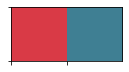

In [48]:
sns.palplot(sns.diverging_palette(10, 220, sep=80, n=2))

In [49]:
# sns.reset_orig()

In [50]:
# # Figure size
# plt.figure(figsize=(10,6))
# palette = ['red','blue']
# sns.set(style="white", context="talk")
# # Seaborn bar plot
# g = sns.barplot(x='Gender',
#                 y='dummy',
#                 data=groupedvalues,
#                 palette = palette
#                )

# # To print the numbers on top of the bar plot
# for index, row in groupedvalues.iterrows():
#     g.text(row.name,row.dummy, round(row.dummy,2), color='black', ha="center", size =16)
    
# # Logistics of plotting

# plt.title('Gender distribution in Director data set 1',fontsize = 16)
# plt.xlabel('Gender', fontsize=16)
# plt.ylabel('Number of directors', fontsize=16)
# plt.tick_params(labelsize=12)
# # plt.savefig('Gender_distribution_in_unbalanced_director_dataset1.png', dpi=100 , bbox_inches='tight')
# plt.show()

## Balanced and Unbalanced Gender distribution in Director data set 1

C:\Users\yuvar\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


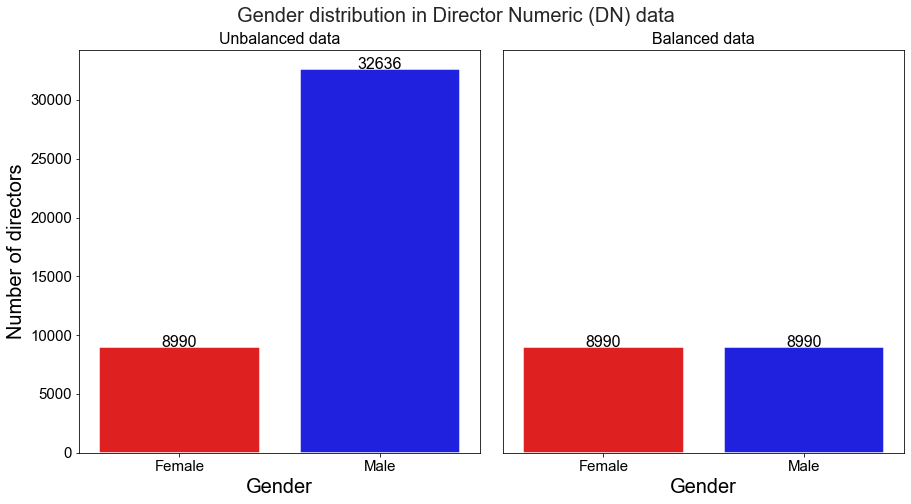

In [51]:
# Sub plots

fig, (ax1,ax2) =plt.subplots(nrows= 1, ncols = 2, figsize=(13, 7) , sharey= True)

# flatten axis if you plan to use fig, ax = ...
# ax = ax.flatten()


# Figure size
# plt.figure(figsize=(10,6))
palette = ['red','blue']
sns.set(style="white", context="talk")

# Seaborn bar plot
g = sns.barplot(x='Gender',
                y='dummy',
                data=groupedvalues,
                palette = palette,
                saturation = 0.75,
                ax = ax1
               )

# To print the numbers on top of the bar plot
for index, row in groupedvalues.iterrows():
    g.text(row.name,row.dummy, round(row.dummy,2), color='black', ha="center", size =16)

    
    
# Seaborn bar plot - balanced
g1 = sns.barplot(x='Gender',
                y='dummy',
                data=balanced_grouped_values,
                palette = palette,
                saturation = 0.75,
                ax = ax2
               )

# To print the numbers on top of the bar plot
for index, row in balanced_grouped_values.iterrows():
    g1.text(row.name,row.dummy, round(row.dummy,2), color='black', ha="center", size =16)    
    
# Logistics of plotting

ax1.set_xlabel('Gender', fontsize=20)
ax2.set_xlabel('Gender', fontsize=20)


ax1.set_ylabel('Number of directors', fontsize=20)
# ax2.set_ylabel('Number of directors', fontsize=20)
ax2.yaxis.set_visible(False) # same for y axis.


ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

ax1.set_title('Unbalanced data',fontsize = 16)
ax2.set_title('Balanced data',fontsize = 16)
fig.suptitle('Gender distribution in Director Numeric (DN) data', fontsize=20, y = 1.01)


# fig.savefig('Gender_distribution_in_unbalanced_balanced_director_DirectorNumericData.png', dpi=100 , bbox_inches='tight')
fig.show()
fig.tight_layout()

# 2. Distribution of gender across success class of a director

## Working - Unbalanced

In [52]:
# # Figure size
# plt.figure(figsize=(8,6))

# palette = ['red','blue']

# # x, percentage, hue = "Gender", "Percentage", "director_class"
# x, percentage, hue = "director_class", "Percentage", "Gender"
# hue_order = ["terrible", "poor",'average','excellent']

# # Generate the dataframe with normalized value count of each class with respect to gender
# percentage_df = visualize_data[x].groupby(visualize_data[hue]).value_counts(normalize=True).rename(percentage).reset_index()
# # g =percentage_df.pipe((sns.barplot, "data"), x=x, y=percentage, hue=hue)
# g = sns.barplot(x='director_class',
#                 y='Percentage',
#                 hue= 'Gender',
#                 data=percentage_df,
#                 palette = palette
#                )



# # Logistics of plotting

# plt.title("Distribution of gender across the success measure, director class",fontsize = 16)
# plt.xlabel('Director Class', fontsize=16)
# plt.ylabel('Proportion', fontsize=16)
# plt.tick_params(labelsize=12)

# # plt.axis('off')
# plt.legend(title = 'Gender' ,bbox_to_anchor=(1.3, 0.5), loc='right', ncol=1,fontsize = 16)
# # plt.savefig('Director_Gender_distribution_across_success_class.png', dpi=100, bbox_inches='tight')
# plt.show()


## Working Balanced

In [53]:
# # Figure size
# plt.figure(figsize=(8,6))

# palette = ['red','blue']

# # x, percentage, hue = "Gender", "Percentage", "director_class"
# x, percentage, hue = "director_class", "Percentage", "Gender"
# hue_order = ["terrible", "poor",'average','excellent']

# # Generate the dataframe with normalized value count of each class with respect to gender
# balanced_percentage_df = balanced_visualize_data[x].groupby(balanced_visualize_data[hue]).value_counts(normalize=True).rename(percentage).reset_index()
# # g =percentage_df.pipe((sns.barplot, "data"), x=x, y=percentage, hue=hue)
# g = sns.barplot(x='director_class',
#                 y='Percentage',
#                 hue= 'Gender',
#                 data=balanced_percentage_df,
#                 palette = palette
#                )



# # Logistics of plotting

# plt.title("Distribution of gender across the success measure, director class",fontsize = 16)
# plt.xlabel('Director Class', fontsize=16)
# plt.ylabel('Proportion', fontsize=16)
# plt.tick_params(labelsize=12)

# # plt.axis('off')
# plt.legend(title = 'Gender' ,bbox_to_anchor=(1.3, 0.5), loc='right', ncol=1,fontsize = 16)
# # plt.savefig('Director_Gender_distribution_across_success_class.png', dpi=100, bbox_inches='tight')
# plt.show()


## Combining the plots

C:\Users\yuvar\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


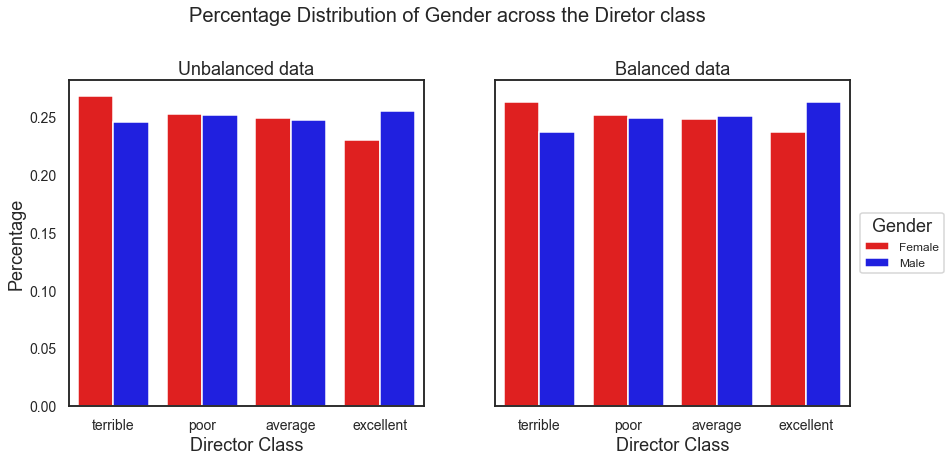

In [54]:
fig, axes =plt.subplots(nrows= 1, ncols = 2, figsize=(14, 6) , sharey= True)
ax1 , ax2 = axes.flatten()

palette = ['red','blue']

x, percentage, hue = "director_class", "Percentage", "Gender"
order = ["terrible", "poor",'average','excellent']
hue_order = ['Female','Male']


# Generate the dataframe with normalized value count of each class with respect to gender
percentage_df = visualize_data[x].groupby(visualize_data[hue]).value_counts(normalize=True).rename(percentage).reset_index()
# g =percentage_df.pipe((sns.barplot, "data"), x=x, y=percentage, hue=hue)
g = sns.barplot(x='director_class',
                order= order,
                y='Percentage',
                hue= 'Gender',
                hue_order = hue_order,
                data=percentage_df,
                palette = palette,
                ax = ax1
               ).set_title("Unbalanced data",fontsize = 18)

ax1.get_legend().remove()


# Generate the dataframe with normalized value count of each class with respect to gender
balanced_percentage_df = balanced_visualize_data[x].groupby(balanced_visualize_data[hue]).value_counts(normalize=True).rename(percentage).reset_index()
# g =percentage_df.pipe((sns.barplot, "data"), x=x, y=percentage, hue=hue)
g1 = sns.barplot(x='director_class',
                 order= order,
                 y='Percentage',    
                 hue= 'Gender',
                 hue_order = hue_order,
                 data=balanced_percentage_df,
                 palette = palette,
                 ax = ax2
               ).set_title("Balanced data",fontsize = 18)

ax2.legend(title='Gender' , bbox_to_anchor=(1.28, 0.5), loc='right', ncol=1,fontsize=12)

for i,ax in enumerate(axes.flat):
    ax.tick_params(labelsize=14)
    ax.set_xlabel('Director Class')
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

ax2.set_ylabel('') 

fig.suptitle('Percentage Distribution of Gender across the Diretor class', fontsize=20, y = 1.05)
    
# fig.savefig('Percentage Distribution of Gender across the Diretor class_Entire Director data.png', dpi=100 , bbox_inches='tight')

# fig.tight_layout()
fig.show()

In [ ]:
plt.get_backend()

In [ ]:
# # Plotting a bar graph of the number of stores in each city, for the first ten cities listed
# # in the column 'City'
# gender_count  = visualize_data['Gender'].value_counts()
# plt.figure(figsize=(8,6))
# g = sns.barplot(gender_count.index, gender_count.values, alpha=0.8)
# plt.title('Gender distribution in Director data set 1')
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.xlabel('Gender', fontsize=12)
# plt.show()

## 3. Swarm plot

# Slow can test later

In [ ]:
# sns.swarmplot(x=chosen_success_class, y=chosen_feature_predicting, data=visualize_data)

## 4. Histogram grouped by categories in same plot - Not working

# Not working yet

In [ ]:
visualize_data[chosen_success_class].value_counts().index

In [ ]:
order = ["terrible", "poor",'average','excellent']

x1 = visualize_data.loc[visualize_data[chosen_success_class] == order[0], 'Gender']
x2 = visualize_data.loc[visualize_data[chosen_success_class] == order[1], chosen_feature_predicting]
x3 = visualize_data.loc[visualize_data[chosen_success_class] == order[2], chosen_feature_predicting]
x4 = visualize_data.loc[visualize_data[chosen_success_class] == order[3], chosen_feature_predicting]

kwargs = dict(bins=100)

plt.hist(x1, **kwargs, color='red', label=order[0] )
plt.hist(x2, **kwargs, color='orange', label=order[1], alpha = 0.75)
plt.hist(x3, **kwargs, color='yellow', label=order[2], alpha=0.5)
plt.hist(x4, **kwargs, color='green', label=order[3] , alpha=0.2)
plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
plt.ylim(0,1500)
plt.xlim(0,500)
plt.legend();


## 5. Bar plot with gender and success class

# Not working as intended

In [ ]:
visualize_data['dummy'] = 1

In [ ]:
# gender_count  = visualize_data['Gender'].value_counts()

# Figure size
plt.figure(figsize=(8,6))

# Seaborn bar plot
g = sns.barplot(x='Gender',
                y='dummy',
                data=visualize_data ,
                hue = chosen_success_class,
                order = ['Male','Female'])

# # To print the numbers on top of the bar plot
# for index, row in groupedvalues.iterrows():
#     g.text(row.name,row.dummy, round(row.dummy,2), color='black', ha="center")
    
# Logistics of plotting

plt.title('Gender distribution in Director data set 1',fontsize = 16)
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.legend(title = 'Director Class' ,bbox_to_anchor=(1.25, 0.5), loc='right', ncol=1)
plt.tick_params(labelsize=12)
plt.show()

In [ ]:
visualize_data.drop(columns = 'dummy',inplace = True)

# 6. Correlation with the target class - Mostly for numerical columns

## Working - To be used while writing about average rating count as succes measure

In [ ]:
visualize_data.columns

In [ ]:
visualize_data

In [ ]:
cor = visualize_data[['average_rating_count', 'career_Length', 'birthYear',
       'average_movie_per_year', 'CareerStartYear', 'average_inter_event_time',
       'median_inter_event_time', 'average_rating_value', 'movies_produced']].corr().round(2)

In [ ]:
cor

In [ ]:
correlations = visualize_data.corrwith(visualize_data[chosen_feature_predicting]).to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]

In [ ]:
fig, (ax1,ax2) =plt.subplots(nrows= 1, ncols = 2, figsize=(14, 8) , sharey= True , gridspec_kw={'width_ratios': [1, 2]})

g = sns.heatmap(data = cor,
                annot=True,
                cmap=plt.cm.Reds,
                fmt=".2f",
                annot_kws={'size':12},
                square=True,
                ax = ax2
               ).set_title(label ='Correlation in Director subset data' , y = 1.05)

g1 = sns.heatmap(data = sorted_correlations.to_frame(),
                 cmap=plt.cm.Reds,
                 annot=True,
                 fmt=".2f",
                 annot_kws={'size':14},
                 cbar = False,
                 ax=ax1,
                ).set_title(label ='Correlation with Average rating count' , y = 1.05)



for i,ax in enumerate(axes.flat):
    ax.tick_params(labelsize=8)
#     ax.xaxis.label.set_size(10)
#     ax.yaxis.label.set_size(10)
    

fig.suptitle('Correlation of numerical features in the Director Numeric data', fontsize=20,x = 0.55, y = 1.05)

fig.tight_layout()
fig.savefig('Correlation of numerical features in the Director Numeric data with Average rating count.png', dpi=100 , bbox_inches='tight')


fig.show()

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(8,6))
cor = visualize_data.corr().round(2)
sns.heatmap(data = cor,
            annot=True,
            cmap=plt.cm.Reds,
            fmt=".2f",
            annot_kws={'size':10},
            square=True
           ).set_title(label ='Correlation in Director subset data' , y = 0.95)
plt.tick_params(labelsize=12)
plt.show()

In [ ]:
correlations = visualize_data.corrwith(visualize_data[chosen_feature_predicting]).to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(sorted_correlations.to_frame(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

fig.suptitle('Correlation of numerical features in the Director subset data with average rating count', fontsize=20 , x = 0.45)


# fig.savefig('Correlation of numerical features in the Director subset data.png', dpi=100 , bbox_inches='tight')
fig.show()

## Accuracy of the models

In [ ]:
sns.reset_orig()

In [64]:
accuracy_df = pd.read_csv("Accuracy - Director Subset.csv")

In [65]:
accuracy_df.head()

,Model,Value,Scenario,Dataset,Row Type
0,RF,0.381696,Unbalanced with Gender,DN,Accuracy
1,SVM,0.397550,Unbalanced with Gender,DN,Accuracy
2,GB,0.430699,Unbalanced with Gender,DN,Accuracy
3,XGB,0.428297,Unbalanced with Gender,DN,Accuracy
4,RF,0.382897,Unbalanced without Gender,DN,Accuracy


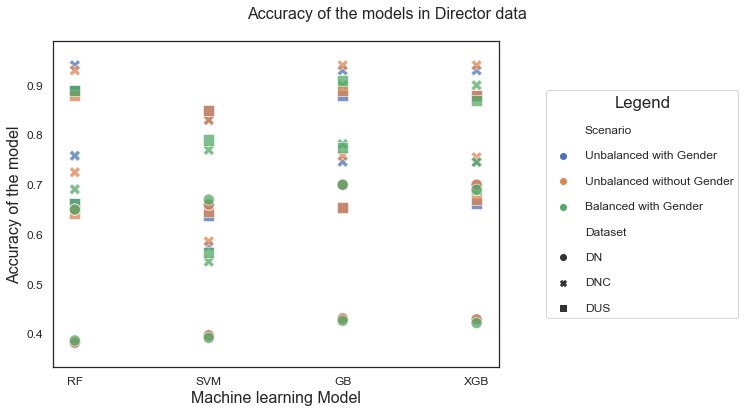

In [66]:
plt.figure(figsize=(8,6))
g2 = sns.scatterplot(x='Model',
                     y='Value',
                     hue= 'Scenario',
                     data=accuracy_df,
                     markers = True,
                     style = 'Dataset',
                     s=125,
                     alpha = 0.75
#                  col = 'Dataset'
#                 palette = palette,
#                  ax = ax2
               )

plt.title('Accuracy of the models in Director data',fontsize = 16, y = 1.05, x = 0.75)
plt.legend(title = 'Legend' ,bbox_to_anchor=(1.55, 0.5), loc='right', ncol=1, fancybox  = True , labelspacing  = 1.25 , fontsize  = 12)
plt.tick_params(labelsize=12)
plt.xlabel('Machine learning Model', fontsize=16)
plt.ylabel('Accuracy of the model', fontsize=16)
# plt.savefig('Accuracy of the models in Director data.png', dpi=100 , bbox_inches='tight')
plt.show()

In [ ]:
sns.reset_orig()

C:\Users\yuvar\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


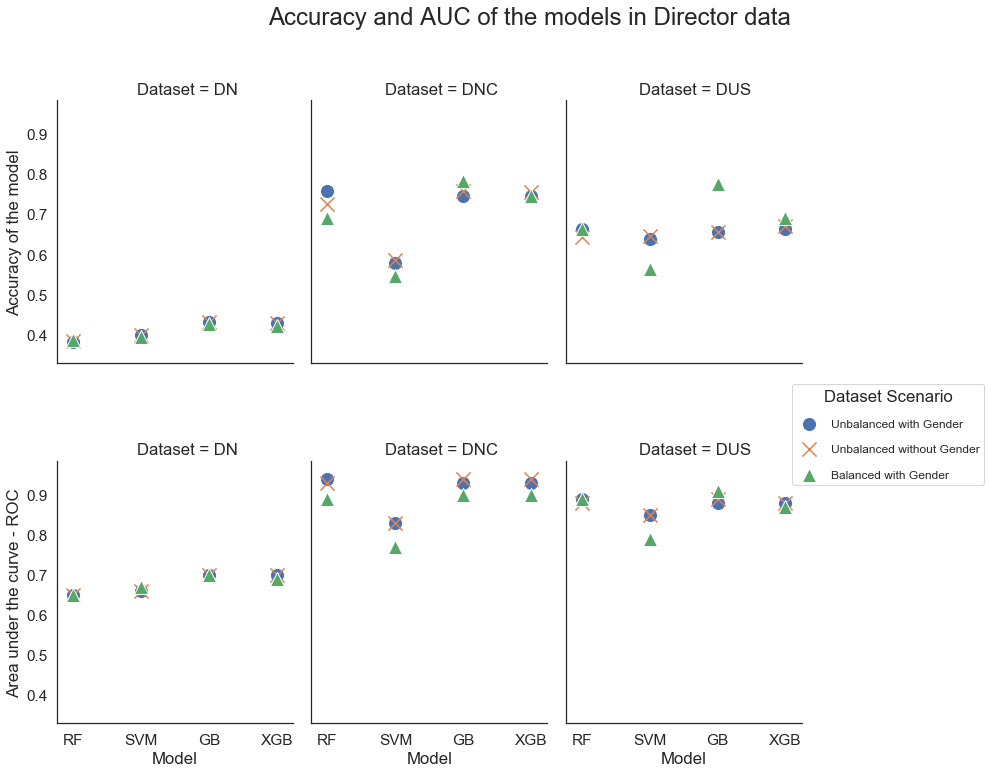

In [67]:
# plt.figure(figsize=(10,6))
sns.set(font_scale=1.4, style = "white") 
g2 = sns.FacetGrid(data=accuracy_df,
                   col = 'Dataset',
                   hue = 'Scenario',
                   row = 'Row Type',
                   hue_order = ['Unbalanced with Gender','Unbalanced without Gender','Balanced with Gender'],
                   height = 5,
                   aspect = 1,
                   sharex = True,
#                    margin_titles=True,
                   hue_kws = dict(marker = ["o","x","^"]))

g2 = (g2.map(plt.scatter, 'Model', "Value", edgecolor="w" , s= 200))
# [plt.setp(ax.texts, text="") for ax in g2.axes.flat]


g2.set_titles("Dataset = {col_name}",fontsize = 20, x = 0.55)
g2.axes[0,0].set_ylabel('Accuracy of the model')
g2.axes[1,0].set_ylabel('Area under the curve - ROC')

g2.fig.suptitle('Accuracy and AUC of the models in Director data',y = 1.08 ,x = 0.50 , fontsize = 24)
plt.legend(title = 'Dataset Scenario' ,bbox_to_anchor=(1.8, 1.1), loc='right', ncol=1, fancybox  = True , labelspacing  = 1.25 , fontsize  = 12)


# g2.set_title('Accuracy of the models in Director data',fontsize = 16, y = 1.05, x = 0.75)
# plt.legend(title = 'Legend' ,bbox_to_anchor=(1.55, 0.5), loc='right', ncol=1, fancybox  = True , labelspacing  = 1.25 , fontsize  = 12)
# plt.tick_params(labelsize=12)
# plt.xlabel('Machine learning Model', fontsize=16)
# plt.ylabel('Accuracy of the model', fontsize=16)
# plt.savefig('Facetgrid_Accuracy_AUC_ROC of the models in Director data.png', dpi=100 , bbox_inches='tight')
g2.fig.tight_layout()
g2.fig.show()

# Box plot distribution - Gender vs numerical features

In [55]:
visualize_data.columns

Index(['movies_produced', 'average_rating_value', 'average_rating_count',
       'career_Length', 'Gender', 'birthYear', 'CareerStartYear',
       'median_inter_event_time', 'average_movie_per_year',
       'average_inter_event_time', 'director_class'],
      dtype='object')

In [56]:
visualize_data.groupby("Gender")['movies_produced'].describe().unstack()

       Gender
count  Female     8990.000000
       Male      32636.000000
mean   Female        5.967631
       Male          8.313549
std    Female       16.454949
       Male         22.584336
min    Female        1.000000
       Male          1.000000
25%    Female        1.000000
       Male          1.000000
50%    Female        2.000000
       Male          2.000000
75%    Female        5.000000
       Male          6.000000
max    Female      397.000000
       Male        821.000000
dtype: float64

In [57]:
visualize_data.groupby("Gender")['career_Length'].median()

Gender
Female    4
Male      5
Name: career_Length, dtype: int64

In [58]:
boxplot_features = visualize_data.columns.values.tolist()
boxplot_features.remove('Gender')
boxplot_features.remove('director_class')
# boxplot_features.remove('new_classification')
boxplot_features


['movies_produced',
 'average_rating_value',
 'average_rating_count',
 'career_Length',
 'birthYear',
 'CareerStartYear',
 'median_inter_event_time',
 'average_movie_per_year',
 'average_inter_event_time']

In [59]:
outlierExclusionList = ['movies_produced','average_rating_count','average_inter_event_time',
                        'median_inter_event_time','average_movie_per_year']

## Function box plot 

In [ ]:
# def box_plot_Xgender_Ynumerical(df,xFeature,yFeatures,outlierExclusionList):
#     axesLength = len(yFeatures)
#     palette = ['red','blue']
    
#     fig, axes = plt.subplots(nrows= 3 , ncols=3, figsize=(14, 6))
#     ax1 , ax2 , ax3 , ax4 , ax5 , ax6 , ax7 , ax8 , ax9 = axes.flatten()

#     for row in range(len(axes)):
#         for col in range(len(axes)):
# #             print('Plot :',str((row * len(axes)) +col ))            
#             if(yFeatures[(row * len(axes)) + col] in outlierExclusionList):
#                 g = sns.boxplot(data = df,
#                                 x = xFeature,
#                                 y = yFeatures[ (row * len(axes)) + col],
#                                 showfliers = False,
#                                 orient='v',
#                                 palette = palette,
#                                 ax = axes[row][col]
#                                ).set_title("Gender vs {0}".format(yFeatures[(row * len(axes)) +col]))
#             else:
#                 g1 = sns.boxplot(data = df,
#                                 x = xFeature,
#                                 y = yFeatures[ (row * len(axes)) + col],
#                                 flierprops = dict(markerfacecolor = '0.50', markersize = 2),
#                                 orient='v',
#                                 palette = palette,
#                                 ax = axes[row][col]
#                                ).set_title("Gender vs {0}".format(yFeatures[(row * len(axes)) +col]))
            

#     plt.subplots_adjust(top=2, bottom=0.1, left=0.10, right=0.85, hspace=0.5,
#                         wspace=0.4)

In [ ]:
# box_plot_Xgender_Ynumerical(df = visualize_data,
#                             xFeature = 'Gender',
#                             yFeatures=boxplot_features,
#                             outlierExclusionList= outlierExclusionList
#                            )

C:\Users\yuvar\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


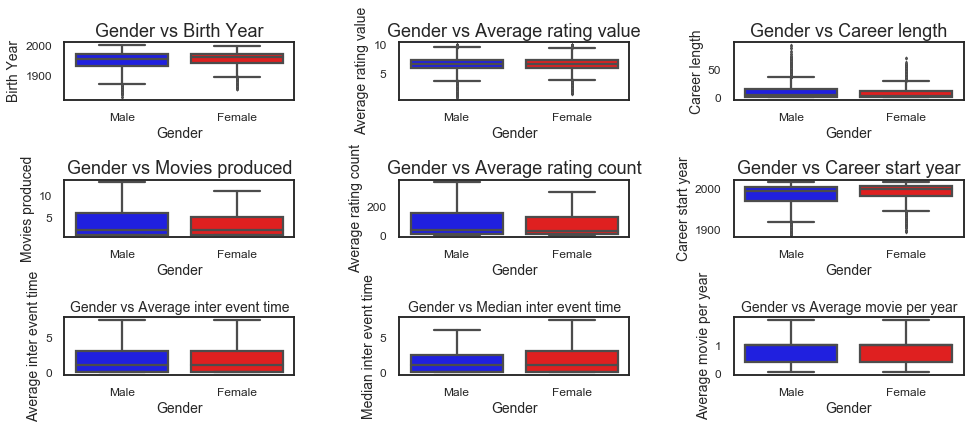

In [60]:
fig, axes = plt.subplots(nrows= 3 , ncols=3, figsize=(14, 6))

ax1 , ax2 , ax3 , ax4 , ax5 , ax6 , ax7 , ax8 , ax9 = axes.flatten()

palette = ['blue','red']

sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'birthYear',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = palette,
            ax = ax1
           ).set_title("Gender vs Birth Year");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_rating_value',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = palette,
            ax = ax2
           ).set_title("Gender vs Average rating value");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'career_Length',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            palette = palette,
            ax = ax3
           ).set_title("Gender vs Career length")


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'movies_produced',
            showfliers = False,
            palette = palette,
            ax = ax4
           ).set_title("Gender vs Movies produced");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_rating_count',
            showfliers = False,
            palette = palette,
            ax = ax5
           ).set_title("Gender vs Average rating count")


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'CareerStartYear',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = palette,
            ax = ax6
           ).set_title("Gender vs Career start year")

sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_inter_event_time',
            showfliers = False,
            palette = palette,
            ax = ax7
           ).set_title("Gender vs Average inter event time", fontsize = 14)


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'median_inter_event_time',
            showfliers = False,
            orient='v',
            palette = palette,
            ax = ax8
           ).set_title("Gender vs Median inter event time",fontsize = 14)


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_movie_per_year',
            showfliers = False,
            orient='v',
            palette = palette,
            ax = ax9
           ).set_title("Gender vs Average movie per year",fontsize = 14)




axis_y_labels = ['Birth Year', 'Average rating value','Career length',
                 'Movies produced','Average rating count','Career start year',
                 'Average inter event time','Median inter event time','Average movie per year']


for i,ax in enumerate(axes.flat):
    ax.tick_params(labelsize=12)
#     ax.set_xlabel('Gender', fontsize=14)
    ax.xaxis.label.set_size(14)
    ax.set_ylabel(axis_y_labels[i], fontsize=14)

# fig.delaxes(ax9)



plt.subplots_adjust(top=2, bottom=0.1, left=0.10, right=0.85, hspace=0.5,
                    wspace=0.4)

# fig.savefig('Box Plots of numerical features with respect to gender.png', dpi=100 , bbox_inches='tight')
fig.show()
fig.tight_layout()

### With outliers

C:\Users\yuvar\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


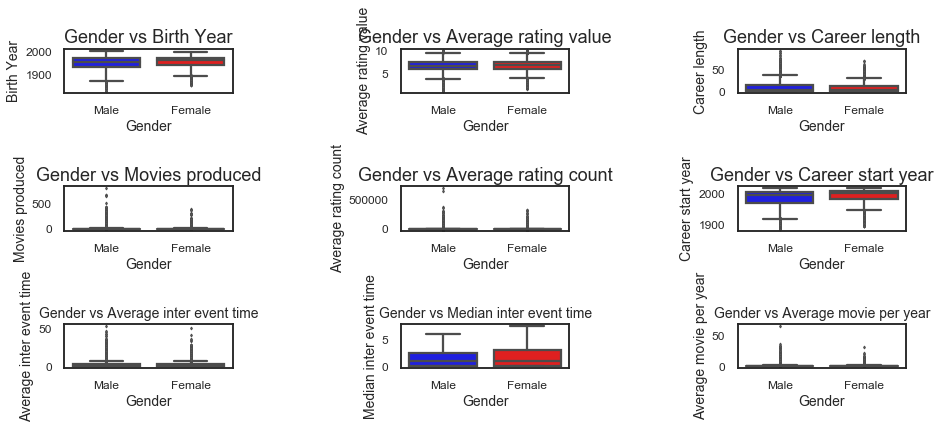

In [62]:
fig, axes = plt.subplots(nrows= 3 , ncols=3, figsize=(14, 6))

ax1 , ax2 , ax3 , ax4 , ax5 , ax6 , ax7 , ax8 , ax9 = axes.flatten()

palette = ['blue','red']

sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'birthYear',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = palette,
            ax = ax1
           ).set_title("Gender vs Birth Year");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_rating_value',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = palette,
            ax = ax2
           ).set_title("Gender vs Average rating value");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'career_Length',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            palette = palette,
            ax = ax3
           ).set_title("Gender vs Career length")


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'movies_produced',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),

#             showfliers = False,
            palette = palette,
            ax = ax4
           ).set_title("Gender vs Movies produced");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_rating_count',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
#             showfliers = False,
            palette = palette,
            ax = ax5
           ).set_title("Gender vs Average rating count")


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'CareerStartYear',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = palette,
            ax = ax6
           ).set_title("Gender vs Career start year")

sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_inter_event_time',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
#             showfliers = False,
            palette = palette,
            ax = ax7
           ).set_title("Gender vs Average inter event time", fontsize = 14)


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'median_inter_event_time',
            showfliers = False,
            orient='v',
            palette = palette,
            ax = ax8
           ).set_title("Gender vs Median inter event time",fontsize = 14)


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_movie_per_year',
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
#             showfliers = False,
            orient='v',
            palette = palette,
            ax = ax9
           ).set_title("Gender vs Average movie per year",fontsize = 14)




axis_y_labels = ['Birth Year', 'Average rating value','Career length',
                 'Movies produced','Average rating count','Career start year',
                 'Average inter event time','Median inter event time','Average movie per year']


for i,ax in enumerate(axes.flat):
    ax.tick_params(labelsize=12)
#     ax.set_xlabel('Gender', fontsize=14)
    ax.xaxis.label.set_size(14)
    ax.set_ylabel(axis_y_labels[i], fontsize=14)

# fig.delaxes(ax9)



plt.subplots_adjust(top=2, bottom=0.1, left=0.10, right=0.85, hspace=0.5,
                    wspace=0.4)

fig.savefig('Box Plots of numerical features with respect to gender with Outliers.png', dpi=100 , bbox_inches='tight')
fig.show()
fig.tight_layout()

### Box plot of Gender against birth year hue director class

In [ ]:
visualize_data.columns

## Hue = Gender , X = Director_ class

In [ ]:
fig, axes = plt.subplots(nrows= 3 , ncols=3, figsize=(14, 6))

ax1 , ax2 , ax3 , ax4 , ax5 , ax6 , ax7 , ax8 , ax9 = axes.flatten()

hue_order = ['Female','Male']
hue_color = ['red','blue']
order = ["terrible", "poor",'average','excellent']

sns.boxplot(data = visualize_data,
            x = 'director_class',
            y = 'birthYear',
            hue = 'Gender',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax1
           ).set_title("Gender vs Birth Year");


sns.boxplot(data = visualize_data,
            x = 'director_class',
            y = 'average_rating_value',
            hue = 'Gender',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax2
           ).set_title("Gender vs Average rating value");


sns.boxplot(data = visualize_data,
            x = 'director_class',
            y = 'career_Length',
            hue = 'Gender',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            palette = hue_color,
            ax = ax3
           ).set_title("Gender vs Career length")


sns.boxplot(data = visualize_data,
            x = 'director_class',
            y = 'movies_produced',
            hue = 'Gender',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax4
           ).set_title("Gender vs Movies produced");


sns.boxplot(data = visualize_data,
            x = 'director_class',
            y = 'average_rating_count',
            hue = 'Gender',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax5
           ).set_title("Gender vs Average rating count")


sns.boxplot(data = visualize_data,
            x = 'director_class',
            y = 'CareerStartYear',
            hue = 'Gender',
            hue_order = hue_order,
            order = order,            
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax6
           ).set_title("Gender vs Career start year")

sns.boxplot(data = visualize_data,
            x = 'director_class',
            y = 'average_inter_event_time',
            hue = 'Gender',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax7
           ).set_title("Gender vs Average inter event time",fontsize = 14)


sns.boxplot(data = visualize_data,
            x = 'director_class',
            y = 'median_inter_event_time',
            hue = 'Gender',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            orient='v',
            palette = hue_color,
            ax = ax8
           ).set_title("Gender vs Median inter event time",fontsize = 14)




axis_y_labels = ['Birth Year', 'Average rating value','Career length',
                 'Movies produced','Average rating count','Career start year',
                 'Average inter event time','Median inter event time','remove']


for i,ax in enumerate(axes.flat):
    if(i == 8):
        fig.delaxes(ax)
    else:
        ax.tick_params(labelsize=12)
    #     ax.set_xlabel('Gender', fontsize=14)
        ax.xaxis.label.set_size(14)
        ax.set_ylabel(axis_y_labels[i], fontsize=14)
        ax.get_legend().remove()

        
fig.suptitle('Distribution of Gender across the Diretor class with respect to numerical features', fontsize=20, y = 2.15)
ax8.legend(title='Gender' , bbox_to_anchor=(2.2, 0.5), loc='right', ncol=1,fontsize=16 , handlelength=2, borderpad=1.2, labelspacing=2)


plt.subplots_adjust(top=2, bottom=0.1, left=0.10, right=0.85, hspace=0.5,
                    wspace=0.4)

fig.savefig('Hue Gender - Director class vs numerical features.png', dpi=100 , bbox_inches='tight')
fig.show()
fig.tight_layout()

## Hue = Director Class , X =  Gender

In [ ]:
fig, axes = plt.subplots(nrows= 3 , ncols=3, figsize=(14, 6))

ax1 , ax2 , ax3 , ax4 , ax5 , ax6 , ax7 , ax8 , ax9 = axes.flatten()

order = ['Female','Male']
hue_color = ['red','orange','yellow','green']
hue_order = ["terrible", "poor",'average','excellent']

sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'birthYear',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax1
           ).set_title("Gender vs Birth Year");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_rating_value',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax2
           ).set_title("Gender vs Average rating value");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'career_Length',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            palette = hue_color,
            ax = ax3
           ).set_title("Gender vs Career length")


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'movies_produced',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax4
           ).set_title("Gender vs Movies produced");


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_rating_count',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax5
           ).set_title("Gender vs Average rating count")


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'CareerStartYear',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax6
           ).set_title("Gender vs Career start year")

sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'average_inter_event_time',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax7
           ).set_title("Gender vs Average inter event time",fontsize = 14)


sns.boxplot(data = visualize_data,
            x = 'Gender',
            y = 'median_inter_event_time',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            orient='v',
            palette = hue_color,
            ax = ax8
           ).set_title("Gender vs Median inter event time",fontsize = 14)




axis_y_labels = ['Birth Year', 'Average rating value','Career length',
                 'Movies produced','Average rating count','Career start year',
                 'Average inter event time','Median inter event time','remove']


for i,ax in enumerate(axes.flat):
    if(i == 8):
        fig.delaxes(ax)
    else:
        ax.tick_params(labelsize=12)
    #     ax.set_xlabel('Gender', fontsize=14)
        ax.xaxis.label.set_size(14)
        ax.set_ylabel(axis_y_labels[i], fontsize=14)
        ax.get_legend().remove()

        
fig.suptitle('Distribution of Gender across the Diretor class with respect to numerical features', fontsize=20, y = 2.15)
ax8.legend(title='Director Class' , bbox_to_anchor=(2.2, 0.5), loc='right', ncol=1,fontsize=16 , handlelength=2, borderpad=1.2, labelspacing=1)


plt.subplots_adjust(top=2, bottom=0.1, left=0.10, right=0.85, hspace=0.5,
                    wspace=0.4)

fig.savefig('Hue Director class - Gender vs numerical features.png', dpi=100 , bbox_inches='tight')
fig.show()
fig.tight_layout()

## Balanced Data Hue = Director Class , X =  Gender

In [ ]:
fig, axes = plt.subplots(nrows= 3 , ncols=3, figsize=(14, 6))

ax1 , ax2 , ax3 , ax4 , ax5 , ax6 , ax7 , ax8 , ax9 = axes.flatten()

order = ['Female','Male']
hue_color = ['red','orange','yellow','green']
hue_order = ["terrible", "poor",'average','excellent']

sns.boxplot(data = balanced_visualize_data,
            x = 'Gender',
            y = 'birthYear',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax1
           ).set_title("Gender vs Birth Year");


sns.boxplot(data = balanced_visualize_data,
            x = 'Gender',
            y = 'average_rating_value',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax2
           ).set_title("Gender vs Average rating value");


sns.boxplot(data = balanced_visualize_data,
            x = 'Gender',
            y = 'career_Length',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            palette = hue_color,
            ax = ax3
           ).set_title("Gender vs Career length")


sns.boxplot(data = balanced_visualize_data,
            x = 'Gender',
            y = 'movies_produced',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax4
           ).set_title("Gender vs Movies produced");


sns.boxplot(data = balanced_visualize_data,
            x = 'Gender',
            y = 'average_rating_count',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax5
           ).set_title("Gender vs Average rating count")


sns.boxplot(data = balanced_visualize_data,
            x = 'Gender',
            y = 'CareerStartYear',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
            orient='v',
            palette = hue_color,
            ax = ax6
           ).set_title("Gender vs Career start year")

sns.boxplot(data = balanced_visualize_data,
            x = 'Gender',
            y = 'average_inter_event_time',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            palette = hue_color,
            ax = ax7
           ).set_title("Gender vs Average inter event time",fontsize = 14)


sns.boxplot(data = balanced_visualize_data,
            x = 'Gender',
            y = 'median_inter_event_time',
            hue = 'director_class',
            hue_order = hue_order,
            order = order,            
            showfliers = False,
            orient='v',
            palette = hue_color,
            ax = ax8
           ).set_title("Gender vs Median inter event time",fontsize = 14)




axis_y_labels = ['Birth Year', 'Average rating value','Career length',
                 'Movies produced','Average rating count','Career start year',
                 'Average inter event time','Median inter event time','remove']


for i,ax in enumerate(axes.flat):
    if(i == 8):
        fig.delaxes(ax)
    else:
        ax.tick_params(labelsize=12)
    #     ax.set_xlabel('Gender', fontsize=14)
        ax.xaxis.label.set_size(14)
        ax.set_ylabel(axis_y_labels[i], fontsize=14)
        ax.get_legend().remove()

        
fig.suptitle('Distribution of Gender across the Diretor class with respect to numerical features', fontsize=20, y = 2.15)
ax8.legend(title='Director Class' , bbox_to_anchor=(2.2, 0.5), loc='right', ncol=1,fontsize=16 , handlelength=2, borderpad=1.2, labelspacing=1)


plt.subplots_adjust(top=2, bottom=0.1, left=0.10, right=0.85, hspace=0.5,
                    wspace=0.4)

fig.savefig('Balanced_Hue Director class - Gender vs numerical features.png', dpi=100 , bbox_inches='tight')
fig.show()
fig.tight_layout()

## Random

In [ ]:
hue_order = ["terrible", "poor",'average','excellent']
hue_order_color = ['red','orange','yellow','green']

sns.boxplot(x = 'director_class',
            y = 'movies_produced',
            data = balanced_visualize_data,
            showfliers = False,
            hue= 'Gender',
#             hue_order = hue_order,
#             palette = hue_order_color,
            flierprops = dict(markerfacecolor = '0.50', markersize = 2),
           ).set_title('Gender vs. Birth Year');

plt.legend(title = 'Director Class' ,bbox_to_anchor=(1.3, 0.5), loc='right', ncol=1,fontsize = 10)


# Contingency Table

In [ ]:
contingency_table_success_gender = pd.crosstab(visualize_data[chosen_success_class], visualize_data['Gender'])
contingency_table_success_gender

In [ ]:
balanced_contingency_table_success_gender = pd.crosstab(balanced_visualize_data[chosen_success_class], visualize_data['Gender'])
balanced_contingency_table_success_gender

In [ ]:
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(nrows= 1 , ncols=2, figsize=(14, 6) ,  sharey= True)
ax1 , ax2 = axes.flatten()

palette = ['red','blue']

sns.set(style="white", context="talk")

contingency_table_success_gender.set_index(contingency_table_success_gender.index)\
                                .plot(kind='bar',
                                      colormap=ListedColormap(sns.color_palette(palette)),
                                      alpha = 0.75,
                                      ax = ax1,
                                      stacked=True
                                     ).set_title('Unbalanced Gender', fontsize = 18)
ax1.get_legend().remove()

balanced_contingency_table_success_gender.set_index(balanced_contingency_table_success_gender.index)\
                                .plot(kind='bar',
                                      colormap=ListedColormap(sns.color_palette(palette)),
                                      alpha = 0.75,
                                      ax = ax2,
                                      stacked=True
                                     ).set_title('Balanced Gender', fontsize = 18)

ax2.legend(title='Gender' , bbox_to_anchor=(1.28, 0.5), loc='right', ncol=1,fontsize=12)

for i,ax in enumerate(axes.flat):
    ax.tick_params(labelsize=14)
#     ax.set_xlabel('Gender', fontsize=14)
    ax.xaxis.label.set_size(18)



fig.suptitle('Distribution of Gender against the success measure class', fontsize=20, y = 1.05)

plt.subplots_adjust(top=0.9, bottom=-0.1, left=0.05, right=0.95, hspace=0.5,
                    wspace=0.2)

# fig.savefig('Balanced and Unbalanced Distribution of Gender against the success measure class.png', dpi=100 , bbox_inches='tight')
fig.show()
fig.tight_layout()

## Working - Unbalanced

In [ ]:
# import seaborn as sns
# from matplotlib.colors import ListedColormap

# palette = ['red','blue']

# sns.set()
# contingency_table_success_gender.set_index(contingency_table_success_gender.index)\
#                                 .plot(kind='bar',
# #                                       colors = pal,
#                                       colormap=ListedColormap(sns.color_palette(palette)),
#                                       alpha = 1,
#                                       figsize=(8,6),
#                                       stacked=True)

# plt.title('Distribution of Gender against the success measure class', fontsize = 20)
# plt.legend(title='Gender' , bbox_to_anchor=(1.25, 0.5), loc='right', ncol=1,fontsize=12)
# plt.ylabel('Number of Occurrences', fontsize=16)
# plt.xlabel('Director Class', fontsize=16)
# plt.tick_params(labelsize=12)
# plt.show()


## Working - Balanced

In [ ]:
# import seaborn as sns
# from matplotlib.colors import ListedColormap

# palette = ['red','blue']
# sns.set(style = 'white')
# balanced_contingency_table_success_gender.set_index(balanced_contingency_table_success_gender.index)\
#                                 .plot(kind='bar',
#                                       colormap=ListedColormap(sns.color_palette(palette, 10)),
#                                       figsize=(8,6),
#                                       stacked=True)

# plt.title('Distribution of Gender against the success measure class', fontsize = 20)
# plt.legend(title='Gender' , bbox_to_anchor=(1.25, 0.5), loc='right', ncol=1,fontsize=12)
# plt.ylabel('Number of Occurrences', fontsize=16)
# plt.xlabel('Director Class', fontsize=16)
# plt.tick_params(labelsize=12)
# plt.show()


In [ ]:
# plt.figure(figsize=(12,8))
# contingency_table_success_gender.plot.bar(stacked=True)
# plt.title('Distribution of Gender against the success measure class')
# plt.legend(title='Gender' , bbox_to_anchor=(1.25, 0.5), loc='right', ncol=1)
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.xlabel('Director Class', fontsize=12)
# plt.show()

### LM Plot

In [ ]:
sns.lmplot(data=visualize_data,
           x= chosen_feature_predicting, 
           y= 'movies_produced', 
           col=chosen_success_class,
           truncate=True,
           hue="Gender"
#            hue_order = ['terrible','poor','average','excellent'],
#            palette = ['red','orange','yellow','green']
          )

## Create 10 new segments of average rating count

In [ ]:
def quartile_bin_10(df,chosen_success_class = chosen_success_class, class_feature='rating_value'):
    # Quartile cut into 4 different buckets
    buckets = 10
    buckets_name = ['Class '+ str(i+1) for i in range(10)]
    cutIntoQuartiles = pd.qcut(df[class_feature].to_list(), q= buckets ,labels=buckets_name)
    
    print(cutIntoQuartiles.categories)
    
    df[chosen_success_class] = cutIntoQuartiles
    df[chosen_success_class] = df[chosen_success_class].astype(object)
    print('The shape of our dataset before dropping the class feature is:', df.shape)
#     df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our dataset after dropping the class feature  is:', df.shape)
    return df

In [ ]:
cutInto10Quartiles = pd.qcut(visualize_data[chosen_feature_predicting].to_list(), q=10)
print("Quantiles bin range")
for i,num in enumerate(cutInto10Quartiles.categories):
    print("Quantile {0} : {1} ".format(i,num))

In [ ]:
visualize_data = quartile_bin_10(visualize_data , class_feature = chosen_feature_predicting , chosen_success_class = 'new_classification')
visualize_data.head()

In [ ]:
contingency_table_new_success_gender = pd.crosstab(visualize_data['new_classification'], visualize_data['Gender'])
contingency_table_new_success_gender

In [ ]:
plt.figure(figsize=(8,6))
contingency_table_new_success_gender.plot.bar(stacked=True)
plt.title('Distribution of Gender against the new success measure class')
plt.legend(title='Gender' , bbox_to_anchor=(1.25, 0.5), loc='right', ncol=1)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Director Class', fontsize=12)
plt.show()

# Viktor proposed bar plots

In [ ]:
accuracy_roc_df = pd.read_csv('Accuracy Bar plots.csv')

In [ ]:
accuracy_roc_df.head()

In [ ]:
sns.reset_orig()

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="x", y="y", hue="hue", data=accuracy_roc_df)
plt.legend(title = 'Models' ,bbox_to_anchor=(1.3, 0.5), loc='right', ncol=1,fontsize = 16)